In [54]:
import requests
import bs4
from bs4 import BeautifulSoup
import pandas as pd
import urllib
import numpy as np
import time
from time import sleep
import csv
import sklearn
from sklearn.linear_model import LogisticRegression
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt
plt.style.use('seaborn-white')
from sklearn.grid_search import GridSearchCV
from sklearn.model_selection import train_test_split

%matplotlib inline

## Trying to scrape from indeed(USA)
Scraping by parts to test out the code
After that form a loop using BeautifulSoup and Selenium to scrape

In [ ]:
URL = "http://www.indeed.com/jobs?q=data+scientist+%2420%2C000&l=New+York&start=10"

In [ ]:
page = requests.get(URL)
#specifying a desired format of “page” using the html parser - this allows python to read the various components of the page, rather than treating it as one long string.
soup = BeautifulSoup(page.text, "html.parser")
#printing soup in a more structured tree format that makes for easier reading
print(soup.prettify())

In [ ]:
#By job titles
def extract_job_title_from_result(soup):
    jobs = []
    for div in soup.find_all(name="div", attrs={"class":"row"}):
        for a in div.find_all(name="a", attrs={"data-tn-element":"jobTitle"}):
            jobs.append(a["title"])
    return(jobs)
extract_job_title_from_result(soup)

In [ ]:
#By company name
def extract_company_from_result(soup): 
    companies = []
    for div in soup.find_all(name="div", attrs={"class":"row"}):
        company = div.find_all(name="span", attrs={"class":"company"})
        if len(company) > 0:
            for b in company:
                companies.append(b.text.strip())
        else:
            sec_try = div.find_all(name="span", attrs={"class":"result-link-source"})
            for span in sec_try:
                companies.append(span.text.strip())
    return(companies)
 
extract_company_from_result(soup)


In [ ]:
# By salary but failed
def extract_salary_from_result(soup): 
    salaries = []
    for div in soup.find_all(name="div", attrs={"class":"row"}):
        try:
            salaries.append(div.find('nobr').text)
        except:
            try:
                div_two = div.find(name="div", attrs={"class":"sjcl"})
                div_three = div_two.find("div")
                salaries.append(div_three.text.strip())
            except:
                salaries.append("Nothing_found")
    return(salaries)
extract_salary_from_result(soup)

In [ ]:
# Summary of the job
def extract_summary_from_result(soup): 
    summaries = []
    spans = soup.findAll('span', attrs={'class': 'summary'})
    for span in spans:
        summaries.append(span.text.strip())
    return(summaries)
extract_summary_from_result(soup)

# Trying with Selenium to see if it works

In [ ]:
import os
from selenium import webdriver


#CHANGE THIS WITH THE RIGHT PATH!
chromedriver = "/Users/Serotonin/Desktop/Ga/materials/classes/week-06/labs/python-webscraping_opentable-lab-master/chromedriver/chromedriver2"
#os.environ["webdriver.chrome.driver"] = chromedriver

In [ ]:
driver= webdriver.Chrome(chromedriver)
driver.get("https://www.indeed.com/jobs?q=data+scientist+%2420%2C000&l=New+York&start=60")
sleep(1)
html = driver.page_source

In [ ]:
soup = BeautifulSoup(html, "lxml")
#printing soup in a more structured tree format that makes for easier reading
#print(soup.prettify())

In [ ]:
def extract_job_title_from_result(soup):
    jobs = []
    for div in soup.find_all(name="div", attrs={"class":"row"}):
        for a in div.find_all(name="a", attrs={"data-tn-element":"jobTitle"}):
            jobs.append(a["title"])
    return(jobs)
extract_job_title_from_result(soup)

In [ ]:
def extract_salary_from_result(soup): 
    salaries = []
    for div in soup.find_all(name="div", attrs={"class":"row"}):
        try:
            salaries.append(div.find('nobr').text)
        except:
            try:
                div_two = div.find(name="div", attrs={"class":"sjcl"})
                div_three = div_two.find("div")
                salaries.append(div_three.text.strip())
            except:
                salaries.append("Nothing_found")
    return(salaries)
extract_salary_from_result(soup)

# Form loops to scrape and seperate data base on states of USA

In [ ]:
max_results_per_city = 1000
city_set = ['New+York','Chicago','San+Francisco', 'Austin', 'Seattle', 'Los+Angeles', 'Philadelphia', 'Atlanta', 'Dallas', 'Pittsburgh', 'Portland', 'Phoenix', 'Denver', 'Houston', 'Miami', 'Washington+DC', 'Boulder']
columns = ["city", "job_title", "company_name", "location", "summary", "salary"]
sample_df = pd.DataFrame(columns = columns)

In [2]:
df = pd.read_csv('./[filepath].csv')

In [3]:
df.head()

,city,job_title,company_name,location,summary,salary
0,New+York,"Associate Data Scientist, Premium Analytics",Spotify,"New York, NY 10011 (Chelsea area)",You will work with a global team of world-clas...,Na
1,New+York,Data Scientist Summer Intern,WeWork,"New York, NY","Comfortable with quantitative analysis, statis...",Na
2,New+York,Analyst | Data Analysis,New York City OFFICE OF MANAGEMENT & BUDGET,"Manhattan, NY",Data AnalysisJOB TITLE:. Provide assistance to...,Na
3,New+York,"Data Engineer, Baseball Operations",New York Yankees,"Bronx, NY","2+ years of experience with data profiling, da...",Na
4,New+York,Assistant Research Scientist,Health Research Incorporated,"Albany, NY",Analyzing and summarizing project data; The As...,Na


In [4]:
df['city'].value_counts()

Seattle          1000
San+Francisco    1000
New+York         1000
Washington+DC    1000
Pittsburgh       1000
Dallas            998
Los+Angeles       998
Austin            997
Boulder           996
Denver            995
Phoenix           994
Miami             994
Houston           993
Atlanta           993
Philadelphia      992
Chicago           992
Portland          983
Name: city, dtype: int64

In [5]:
df.dtypes

city            object
job_title       object
company_name    object
location        object
summary         object
salary          object
dtype: object

# Data Cleaning
As i was unable to extract out the salary from indeed. I managed to get the Average/Min/Max salary of a data scientist for each states.

I had to make some bad assumptions
### Assumptions
1) All jobs scraped are somewhat related to data science hence get the same salary as a DS.

2) Salary assumed average salary by states and regards of the job title


In [6]:
df['job_title'] = df['job_title'].apply(lambda x: x.lower())
df['company_name'] = df['company_name'].apply(lambda x: x.lower())
df['location'] = df['location'].apply(lambda x: x.lower())
df['summary'] = df['summary'].apply(lambda x: x.lower())

In [7]:
for i in range(df.shape[0]):
    if df['city'][i] == 'New+York':
        df['salary'][i] = 136406

In [8]:
for i in range(df.shape[0]):
    if df['city'][i] == 'Chicago':
        df['salary'][i] = 116090

In [9]:
for i in range(df.shape[0]):
    if df['city'][i] == 'San+Francisco':
        df['salary'][i] = 149986

In [10]:
for i in range(df.shape[0]):
    if df['city'][i] == 'Austin':
        df['salary'][i] = 107475

In [11]:
for i in range(df.shape[0]):
    if df['city'][i] == 'Seattle':
        df['salary'][i] = 138692

In [12]:
for i in range(df.shape[0]):
    if df['city'][i] == 'Los+Angeles':
        df['salary'][i] = 135920

In [13]:
for i in range(df.shape[0]):
    if df['city'][i] == 'Philadelphia':
        df['salary'][i] = 112995

In [14]:
for i in range(df.shape[0]):
    if df['city'][i] == 'Atlanta':
        df['salary'][i] = 101588

In [15]:
for i in range(df.shape[0]):
    if df['city'][i] == 'Dallas':
        df['salary'][i] = 113000

In [16]:
for i in range(df.shape[0]):
    if df['city'][i] == 'Pittsburgh':
        df['salary'][i] = 84930

In [17]:
for i in range(df.shape[0]):
    if df['city'][i] == 'Portland':
        df['salary'][i] = 89740

In [18]:
for i in range(df.shape[0]):
    if df['city'][i] == 'Phoenix':
        df['salary'][i] = 103769

In [19]:
for i in range(df.shape[0]):
    if df['city'][i] == 'Denver':
        df['salary'][i] = 107409

In [20]:
for i in range(df.shape[0]):
    if df['city'][i] == 'Houston':
        df['salary'][i] = 122499

In [21]:
for i in range(df.shape[0]):
    if df['city'][i] == 'Miami':
        df['salary'][i] = 112496

In [22]:
for i in range(df.shape[0]):
    if df['city'][i] == 'Washington+DC':
        df['salary'][i] = 113625

In [23]:
for i in range(df.shape[0]):
    if df['city'][i] == 'Boulder':
        df['salary'][i] = 93695

In [24]:
df.salary.value_counts()

138692    1000
149986    1000
136406    1000
113625    1000
84930     1000
113000     998
135920     998
107475     997
93695      996
107409     995
112496     994
103769     994
101588     993
122499     993
116090     992
112995     992
89740      983
Name: salary, dtype: int64

In [25]:
df.head()

,city,job_title,company_name,location,summary,salary
0,New+York,"associate data scientist, premium analytics",spotify,"new york, ny 10011 (chelsea area)",you will work with a global team of world-clas...,136406
1,New+York,data scientist summer intern,wework,"new york, ny","comfortable with quantitative analysis, statis...",136406
2,New+York,analyst | data analysis,new york city office of management & budget,"manhattan, ny",data analysisjob title:. provide assistance to...,136406
3,New+York,"data engineer, baseball operations",new york yankees,"bronx, ny","2+ years of experience with data profiling, da...",136406
4,New+York,assistant research scientist,health research incorporated,"albany, ny",analyzing and summarizing project data; the as...,136406


In [26]:
df['is_data_scientist'] = df['job_title'].apply(lambda x: 1 if 'data scientist' in x else 0)
df['analyst'] = df['job_title'].apply(lambda x: 1 if 'analyst' in x else 0)
df['engineer'] = df['job_title'].apply(lambda x: 1 if 'engineer' in x else 0)
df['senior'] = df['job_title'].apply(lambda x: 1 if ('senior' in x) or ('sr' in x) or ('sr.' in x) else 0)
df['junior'] = df['job_title'].apply(lambda x: 1 if ('junior' in x) or ('jr' in x) or ('jr.' in x) else 0)


In [ ]:
df.head(100)

In [27]:
df['location'].value_counts().head(20)

austin, tx                                    680
boulder, co                                   659
pittsburgh, pa 15222 (strip district area)    597
houston, tx                                   547
chicago, il                                   544
atlanta, ga                                   473
denver, co                                    470
new york, ny                                  425
seattle, wa                                   407
san francisco, ca                             393
philadelphia, pa                              360
tempe, az                                     349
los angeles, ca                               327
dallas, tx                                    323
portland, or                                  320
beaverton, or 97006 (triple creek area)       248
miami, fl                                     210
dallas, tx 75252 (far north area)             203
fort lauderdale, fl                           200
westminster, co                               198


In [28]:
df = pd.concat([df, pd.get_dummies(df['city'],drop_first = True)], axis=1)

In [29]:
df.head()

,city,job_title,company_name,location,summary,salary,is_data_scientist,analyst,engineer,senior,...,Los+Angeles,Miami,New+York,Philadelphia,Phoenix,Pittsburgh,Portland,San+Francisco,Seattle,Washington+DC
0,New+York,"associate data scientist, premium analytics",spotify,"new york, ny 10011 (chelsea area)",you will work with a global team of world-clas...,136406,1,0,0,0,...,0,0,1,0,0,0,0,0,0,0
1,New+York,data scientist summer intern,wework,"new york, ny","comfortable with quantitative analysis, statis...",136406,1,0,0,0,...,0,0,1,0,0,0,0,0,0,0
2,New+York,analyst | data analysis,new york city office of management & budget,"manhattan, ny",data analysisjob title:. provide assistance to...,136406,0,1,0,0,...,0,0,1,0,0,0,0,0,0,0
3,New+York,"data engineer, baseball operations",new york yankees,"bronx, ny","2+ years of experience with data profiling, da...",136406,0,0,1,0,...,0,0,1,0,0,0,0,0,0,0
4,New+York,assistant research scientist,health research incorporated,"albany, ny",analyzing and summarizing project data; the as...,136406,0,0,0,0,...,0,0,1,0,0,0,0,0,0,0


In [30]:
df2 = df.drop(columns = ['city','location'], axis = 1)

In [31]:
df2.head()

,job_title,company_name,summary,salary,is_data_scientist,analyst,engineer,senior,junior,Austin,...,Los+Angeles,Miami,New+York,Philadelphia,Phoenix,Pittsburgh,Portland,San+Francisco,Seattle,Washington+DC
0,"associate data scientist, premium analytics",spotify,you will work with a global team of world-clas...,136406,1,0,0,0,0,0,...,0,0,1,0,0,0,0,0,0,0
1,data scientist summer intern,wework,"comfortable with quantitative analysis, statis...",136406,1,0,0,0,0,0,...,0,0,1,0,0,0,0,0,0,0
2,analyst | data analysis,new york city office of management & budget,data analysisjob title:. provide assistance to...,136406,0,1,0,0,0,0,...,0,0,1,0,0,0,0,0,0,0
3,"data engineer, baseball operations",new york yankees,"2+ years of experience with data profiling, da...",136406,0,0,1,0,0,0,...,0,0,1,0,0,0,0,0,0,0
4,assistant research scientist,health research incorporated,analyzing and summarizing project data; the as...,136406,0,0,0,0,0,0,...,0,0,1,0,0,0,0,0,0,0


In [32]:
df2.company_name.value_counts().head()

ball aerospace             694
petuum                     578
isenpai                    534
riccione resources, inc    270
carvana                    260
Name: company_name, dtype: int64

In [ ]:
df['high_salary'] = df['salary'].apply(lambda x: 1 if x > 114000 else 0)

In [33]:
df2['high_salary'] = df2['salary'].apply(lambda x: 1 if x > 114000 else 0)


In [34]:
df2.head()

,job_title,company_name,summary,salary,is_data_scientist,analyst,engineer,senior,junior,Austin,...,Miami,New+York,Philadelphia,Phoenix,Pittsburgh,Portland,San+Francisco,Seattle,Washington+DC,high_salary
0,"associate data scientist, premium analytics",spotify,you will work with a global team of world-clas...,136406,1,0,0,0,0,0,...,0,1,0,0,0,0,0,0,0,1
1,data scientist summer intern,wework,"comfortable with quantitative analysis, statis...",136406,1,0,0,0,0,0,...,0,1,0,0,0,0,0,0,0,1
2,analyst | data analysis,new york city office of management & budget,data analysisjob title:. provide assistance to...,136406,0,1,0,0,0,0,...,0,1,0,0,0,0,0,0,0,1
3,"data engineer, baseball operations",new york yankees,"2+ years of experience with data profiling, da...",136406,0,0,1,0,0,0,...,0,1,0,0,0,0,0,0,0,1
4,assistant research scientist,health research incorporated,analyzing and summarizing project data; the as...,136406,0,0,0,0,0,0,...,0,1,0,0,0,0,0,0,0,1


In [35]:
df2.columns

Index(['job_title', 'company_name', 'summary', 'salary', 'is_data_scientist',
       'analyst', 'engineer', 'senior', 'junior', 'Austin', 'Boulder',
       'Chicago', 'Dallas', 'Denver', 'Houston', 'Los+Angeles', 'Miami',
       'New+York', 'Philadelphia', 'Phoenix', 'Pittsburgh', 'Portland',
       'San+Francisco', 'Seattle', 'Washington+DC', 'high_salary'],
      dtype='object')

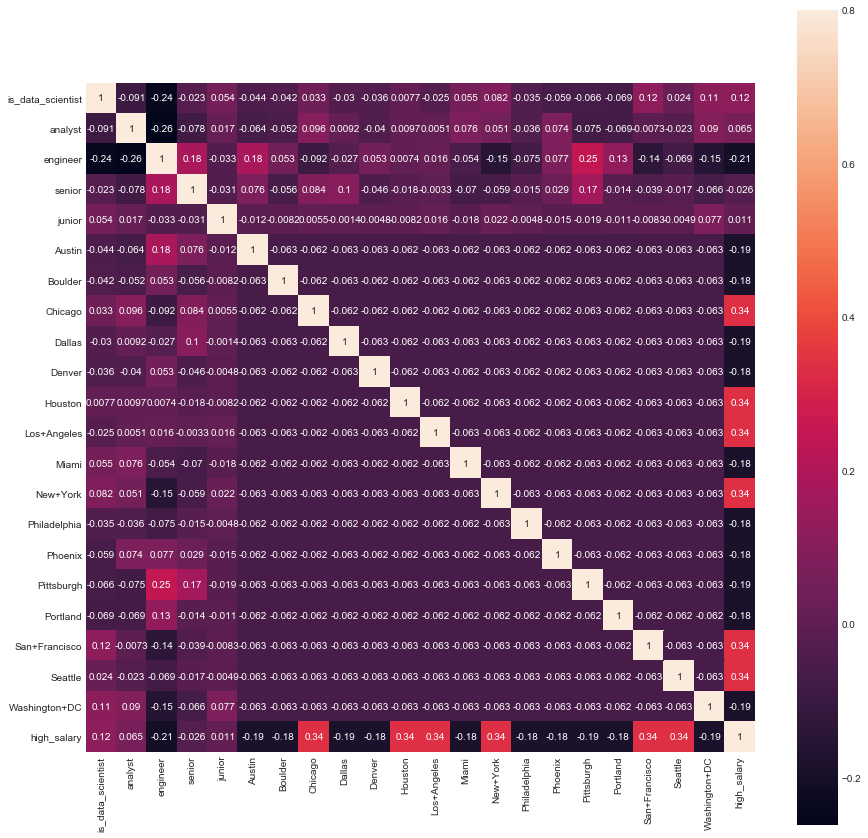

In [36]:
#heat map
corrmat = df2.corr()
f, ax = plt.subplots(figsize=(15, 15))
sns.heatmap(corrmat, vmax=.8, square=True, annot=True);

## Initial model with Logistic Regression 1

Because i modelled using logistic regression first to go through all the model one time before using randomforest, i will now use randomforest classification as well but only for model 1/2/6. The reason is stated below. 
- Model 1/6 because Logistic regression give a close to perfect score so something must be wrong
- Model 2 is just for the sake of see how randomforest do against other features


In [53]:
def examine_coefficients(model, df):
    df = pd.DataFrame({ 'Coefficient' : model.coef_[0] , 
                        'Feature' : df.columns}).sort_values(by='Coefficient')
    return df[df.Coefficient !=0 ]

In [67]:
lr = LogisticRegression()

In [68]:
y = df2['high_salary']
X = df2.iloc[:, 4:-1]

In [57]:
y.shape

(16925,)

In [58]:
X.shape

(16925, 21)

In [69]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 0)

In [70]:
M1 = lr.fit(X_train, y_train)

In [61]:
y_pred = M1.predict(X_test)
confusion_matrix(y_test, y_pred)

array([[2193,    0],
       [   0, 1192]], dtype=int64)

In [62]:
print(classification_report(y_test, y_pred))

             precision    recall  f1-score   support

          0       1.00      1.00      1.00      2193
          1       1.00      1.00      1.00      1192

avg / total       1.00      1.00      1.00      3385



In [132]:
examine_coefficients(M1, X)

#### Randomforest with model 1 data, i will expect it to perform the same or worst

In [133]:
#splitting the data again to be sure
y = df2['high_salary']
X = df2.iloc[:, 4:-1]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 0)

In [134]:
#importing the right model and train it 
from sklearn.ensemble import RandomForestClassifier
classifier = RandomForestClassifier(n_estimators = 10, criterion = 'entropy' , random_state = 0)
classifier.fit(X_train, y_train)

C:\Users\Serotonin\Anaconda3\lib\site-packages\sklearn\ensemble\weight_boosting.py:29: DeprecationWarning: numpy.core.umath_tests is an internal NumPy module and should not be imported. It will be removed in a future NumPy release.
  from numpy.core.umath_tests import inner1d


RandomForestClassifier(bootstrap=True, class_weight=None, criterion='entropy',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=1,
            oob_score=False, random_state=0, verbose=0, warm_start=False)

In [135]:
y_pred = classifier.predict(X_test)
cm = confusion_matrix(y_test, y_pred)
print(cm)
print(classification_report(y_test, y_pred))

[[2193    0]
 [   0 1192]]
             precision    recall  f1-score   support

          0       1.00      1.00      1.00      2193
          1       1.00      1.00      1.00      1192

avg / total       1.00      1.00      1.00      3385



#### Conclusion, there  must be something wrong with my data, but im not sure what it is and its too late to solve it now. =/

## Model with Company names 2

In [136]:
v2 = CountVectorizer(            
    binary=True, 
    stop_words='english',
    max_features=50,
)

dfx2 = v2.fit_transform(df2['company_name']).todense()
dfx2 = pd.DataFrame(dfx2, columns=v2.get_feature_names())
dfx2.head()

,advanced,aerospace,analytics,associates,ball,boeing,burns,cancer,capital,carvana,...,riccione,services,solutions,stolarek,systems,technologies,technology,university,voxtel,xentity
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [137]:
dfx2.columns

Index(['advanced', 'aerospace', 'analytics', 'associates', 'ball', 'boeing',
       'burns', 'cancer', 'capital', 'carvana', 'center', 'company',
       'consulting', 'corporation', 'devices', 'global', 'group', 'health',
       'institute', 'international', 'isenpai', 'kleinfelder', 'laboratory',
       'launch', 'llc', 'mcdonnell', 'medical', 'mete', 'micro', 'minds',
       'national', 'nauwork', 'new', 'neya', 'partners', 'petuum', 'porcaro',
       'rekruiters', 'research', 'resources', 'riccione', 'services',
       'solutions', 'stolarek', 'systems', 'technologies', 'technology',
       'university', 'voxtel', 'xentity'],
      dtype='object')

In [138]:
model2_vars = dfx2.columns

In [77]:
lr2 = LogisticRegression()
y2 = df2['high_salary']
X2 = dfx2[model2_vars]
X_train, X_test, y_train, y_test = train_test_split(X2, y2, test_size = 0.2, random_state = 0)

In [78]:
M2 = lr2.fit(X_train, y_train)

In [79]:
y_pred = M2.predict(X_test)
confusion_matrix(y_test, y_pred)

array([[2085,  108],
       [ 975,  217]], dtype=int64)

In [80]:
print(classification_report(y_test, y_pred))

             precision    recall  f1-score   support

          0       0.68      0.95      0.79      2193
          1       0.67      0.18      0.29      1192

avg / total       0.68      0.68      0.62      3385



In [65]:
examine_coefficients(M2, X2)

,Coefficient,Feature
4,-6.010605,ball
35,-4.428720,petuum
40,-3.940240,riccione
9,-3.803598,carvana
48,-3.764632,voxtel
31,-3.508260,nauwork
49,-2.788712,xentity
0,-2.723112,advanced
23,-2.715327,launch
42,-2.327796,solutions


#### Performing RF based on Company names

In [139]:
y2 = df2['high_salary']
X2 = dfx2[model2_vars]
X_train, X_test, y_train, y_test = train_test_split(X2, y2, test_size = 0.2, random_state = 0)

In [140]:
from sklearn.ensemble import RandomForestClassifier
classifier = RandomForestClassifier(n_estimators = 10, criterion = 'entropy' , random_state = 0)
classifier.fit(X_train, y_train)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='entropy',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=1,
            oob_score=False, random_state=0, verbose=0, warm_start=False)

In [141]:
y_pred = classifier.predict(X_test)
cm = confusion_matrix(y_test, y_pred)
print(cm)
print(classification_report(y_test, y_pred))

[[2093  100]
 [ 945  247]]
             precision    recall  f1-score   support

          0       0.69      0.95      0.80      2193
          1       0.71      0.21      0.32      1192

avg / total       0.70      0.69      0.63      3385



#### In general i think rf will perform better than Lr

## Model with job titles 3

In [81]:
v3 = CountVectorizer(            
    binary=True, 
    stop_words='english',
    max_features=50,
)

dfx3 = v3.fit_transform(df2['job_title']).todense()
dfx3 = pd.DataFrame(dfx3, columns=v3.get_feature_names())
dfx3.head()

,ai,analyst,analytics,architect,associate,big,business,clearance,computer,consultant,...,software,solutions,specialist,splunk,sr,stack,statistical,systems,technical,vision
0,0,0,1,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [87]:
model3_vars = dfx3.columns
lr3 = LogisticRegression()
y3 = df2['high_salary']
X3 = dfx3[model3_vars]
X_train, X_test, y_train, y_test = train_test_split(X3, y3, test_size = 0.2, random_state = 0)

In [88]:
M3 = lr3.fit(X_train, y_train)

In [89]:
y_pred = M2.predict(X_test)
confusion_matrix(y_test, y_pred)

array([[1572,  621],
       [ 717,  475]], dtype=int64)

In [90]:
print(classification_report(y_test, y_pred))

             precision    recall  f1-score   support

          0       0.69      0.72      0.70      2193
          1       0.43      0.40      0.42      1192

avg / total       0.60      0.60      0.60      3385



In [91]:
examine_coefficients(M2, X3)

,Coefficient,Feature
4,-6.010605,associate
35,-4.428720,science
40,-3.940240,software
9,-3.803598,consultant
48,-3.764632,technical
31,-3.508260,project
49,-2.788712,vision
0,-2.723112,ai
23,-2.715327,lead
42,-2.327796,specialist


## Model with Job Summary 4

In [92]:
v4 = CountVectorizer(            
    binary=True, 
    stop_words='english',
    max_features=50,
)

dfx4 = v4.fit_transform(df2['summary']).todense()
dfx4 = pd.DataFrame(dfx4, columns=v4.get_feature_names())
dfx4.head()

,000,ability,ai,analysis,analysts,analytics,architect,big,build,building,...,solutions,staff,support,team,teams,tools,work,working,world,years
0,0,0,0,0,1,0,0,0,0,0,...,0,0,0,1,0,0,1,0,1,0
1,0,0,0,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [94]:
model4_vars = dfx4.columns
lr4 = LogisticRegression()
y4 = df2['high_salary']
X4 = dfx4[model4_vars]
X_train, X_test, y_train, y_test = train_test_split(X4, y4, test_size = 0.2, random_state = 0)

In [96]:
M4 = lr4.fit(X_train, y_train)

In [97]:
y_pred = M4.predict(X_test)
cm = confusion_matrix(y_test, y_pred)
print(cm)
print(classification_report(y_test, y_pred))

[[1962  231]
 [ 850  342]]
             precision    recall  f1-score   support

          0       0.70      0.89      0.78      2193
          1       0.60      0.29      0.39      1192

avg / total       0.66      0.68      0.64      3385



In [98]:
examine_coefficients(M4, X4)

,Coefficient,Feature
0,-2.518610,000
30,-1.210030,operations
16,-0.882960,engineer
2,-0.860389,ai
40,-0.688825,solutions
45,-0.639623,tools
28,-0.578066,managers
23,-0.576794,lead
22,-0.539639,large
27,-0.493386,management


## Model with location 5

In [99]:
v5 = CountVectorizer(            
    binary=True, 
    stop_words='english',
    max_features=50,
)

dfx5 = v5.fit_transform(df['location']).todense()
dfx5 = pd.DataFrame(dfx5, columns=v5.get_feature_names())
dfx5.head()


,15222,75252,97006,angeles,area,atlanta,austin,az,beaverton,boulder,...,seattle,south,strip,tempe,triple,tx,va,wa,washington,york
0,0,0,0,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [100]:
model5_vars = dfx5.columns
lr5 = LogisticRegression()
y5 = df2['high_salary']
X5 = dfx5[model5_vars]
X_train, X_test, y_train, y_test = train_test_split(X5, y5, test_size = 0.2, random_state = 0)

In [101]:
M5 = lr5.fit(X_train, y_train)

In [102]:
y_pred = M5.predict(X_test)
cm = confusion_matrix(y_test, y_pred)
print(cm)
print(classification_report(y_test, y_pred))

[[2169   24]
 [   0 1192]]
             precision    recall  f1-score   support

          0       1.00      0.99      0.99      2193
          1       0.98      1.00      0.99      1192

avg / total       0.99      0.99      0.99      3385



In [103]:
examine_coefficients(M5, X5)

,Coefficient,Feature
33,-2.940360,pa
6,-2.734430,austin
14,-2.273359,dallas
16,-2.148976,denver
19,-2.013351,fl
37,-1.998921,portland
9,-1.961047,boulder
7,-1.848414,az
22,-1.760603,ga
46,-1.744536,va


## Combine all the features into one model

In [104]:
extracted_features = pd.concat([dfx2, dfx3, dfx4, dfx5], axis=1, join_axes=[dfx2.index])

In [105]:
model_6_vars = extracted_features.columns
lr6 = LogisticRegression()
y6 = df2['high_salary']
X6 = extracted_features[model_6_vars]
X_train, X_test, y_train, y_test = train_test_split(X6, y6, test_size = 0.2, random_state = 0)

In [106]:
M6 = lr6.fit(X_train, y_train)

In [109]:
M6.score(X_train, y_train)

0.9981536189069424

In [107]:
y_pred = M6.predict(X_test)
cm = confusion_matrix(y_test, y_pred)
print(cm)
print(classification_report(y_test, y_pred))

[[2191    2]
 [   0 1192]]
             precision    recall  f1-score   support

          0       1.00      1.00      1.00      2193
          1       1.00      1.00      1.00      1192

avg / total       1.00      1.00      1.00      3385



In [108]:
examine_coefficients(M6, X6)

,Coefficient,Feature
243,-3.023943,pa
21,-2.809540,international
214,-2.556542,austin
227,-2.300843,fl
224,-2.282132,denver
222,-2.204153,dallas
256,-1.978732,va
236,-1.957488,md
217,-1.948447,boulder
230,-1.919430,ga


#### RF with all the features

In [142]:
extracted_features3 = pd.concat([dfx2, dfx3, dfx4, dfx5], axis=1, join_axes=[dfx2.index])

In [143]:
model_A_vars = extracted_features3.columns
yA = df2['high_salary']
XA = extracted_features3[model_A_vars]
X_train, X_test, y_train, y_test = train_test_split(XA, yA, test_size = 0.2, random_state = 0)

In [144]:

classifier2 = RandomForestClassifier(n_estimators = 10, criterion = 'entropy' , random_state = 0)
classifier2.fit(X_train, y_train)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='entropy',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=1,
            oob_score=False, random_state=0, verbose=0, warm_start=False)

In [145]:
classifier2.score(X_train, y_train)

1.0

In [147]:
y_pred = classifier2.predict(X_test)
cm = confusion_matrix(y_test, y_pred)
print(cm)
print(classification_report(y_test, y_pred))

[[2191    2]
 [   4 1188]]
             precision    recall  f1-score   support

          0       1.00      1.00      1.00      2193
          1       1.00      1.00      1.00      1192

avg / total       1.00      1.00      1.00      3385



In [ ]:
model_A_vars = extracted_features3.columns
yA = df2['high_salary']
XA = extracted_features3[model_A_vars]
X_train, X_test, y_train, y_test = train_test_split(XA, yA, test_size = 0.2, random_state = 0)

classifier2 = RandomForestClassifier(n_estimators = 10, criterion = 'entropy' , random_state = 0)
classifier2.fit(X_train, y_train)

print(classifier2.score(X_train, y_train))

y_pred = classifier2.predict(X_test)
cm = confusion_matrix(y_test, y_pred)
print(cm)

print(classification_report(y_test, y_pred))

### QUESTION 2: Factors that distinguish job category

Using the job postings you scraped for part 1 (or potentially new job postings from a second round of scraping), identify features in the data related to job postings that can distinguish job titles from each other. There are a variety of interesting ways you can frame the target variable, for example:
- What components of a job posting distinguish data scientists from other data jobs?
- What features are important for distinguishing junior vs. senior positions?
- Do the requirements for titles vary significantly with industry (e.g. healthcare vs. government)?

You may end up making multiple classification models to tackle different questions. Be sure to clearly explain your hypotheses and framing, any feature engineering, and what your target variables are. The type of classification model you choose is up to you. Be sure to interpret your results and evaluate your models' performance.

### Model 7 is to compare data scientist against all other features

In [118]:
extracted_features2 = pd.concat([dfx2, dfx4, dfx5], axis=1, join_axes=[dfx2.index])

In [127]:
model_7_vars = extracted_features2.columns
lr7 = LogisticRegression()
y7 = df2['is_data_scientist']
X7 = extracted_features2[model_7_vars]
X_train, X_test, y_train, y_test = train_test_split(X7, y7, test_size = 0.2, random_state = 0)

In [128]:
M7 = lr7.fit(X_train, y_train)

In [129]:
M7.score(X_train, y_train)

0.9276957163958641

In [130]:
y_pred = M7.predict(X_test)
cm = confusion_matrix(y_test, y_pred)
print(cm)
print(classification_report(y_test, y_pred))

[[2961   54]
 [ 229  141]]
             precision    recall  f1-score   support

          0       0.93      0.98      0.95      3015
          1       0.72      0.38      0.50       370

avg / total       0.91      0.92      0.90      3385



In [131]:
examine_coefficients(M7, X7)

,Coefficient,Feature
38,-2.766165,petuum
43,-2.436807,resources
24,-2.263723,launch
32,-1.905993,nauwork
108,-1.706762,world
11,-1.675334,center
62,-1.570779,architect
129,-1.516277,fl
72,-1.490184,engineer
9,-1.436745,capital


#### RF AND DataScientist

In [148]:
extracted_features2 = pd.concat([dfx2, dfx4, dfx5], axis=1, join_axes=[dfx2.index])

In [149]:
#Select the target/predictor
model_A_vars = extracted_features2.columns
y_b = df2['is_data_scientist']
X_b = extracted_features2[model_A_vars]

#Train/test/split
X_train, X_test, y_train, y_test = train_test_split(X_b, y_b, test_size = 0.2, random_state = 0)

#fit new classifier
classifier3 = RandomForestClassifier(n_estimators = 10, criterion = 'entropy' , random_state = 0)
classifier3.fit(X_train, y_train)

#Score
print(classifier3.score(X_train, y_train))

#Comfusion matrix
y_pred = classifier3.predict(X_test)
cm = confusion_matrix(y_test, y_pred)
print(cm)

#report card
print(classification_report(y_test, y_pred))

0.9880354505169867
[[2947   68]
 [ 199  171]]
             precision    recall  f1-score   support

          0       0.94      0.98      0.96      3015
          1       0.72      0.46      0.56       370

avg / total       0.91      0.92      0.91      3385



### Model 8 compares Seniority with all the features

In [123]:
model_8_vars = extracted_features2.columns
lr8 = LogisticRegression()
y8 = df2['senior']
X8 = extracted_features2[model_7_vars]
X_train, X_test, y_train, y_test = train_test_split(X8, y8, test_size = 0.2, random_state = 0)

In [124]:
M8 = lr8.fit(X_train, y_train)

In [126]:
M8.score(X_train, y_train)

0.8609305760709011

In [125]:
y_pred = M8.predict(X_test)
cm = confusion_matrix(y_test, y_pred)
print(cm)
print(classification_report(y_test, y_pred))

[[2574  110]
 [ 342  359]]
             precision    recall  f1-score   support

          0       0.88      0.96      0.92      2684
          1       0.77      0.51      0.61       701

avg / total       0.86      0.87      0.86      3385



In [117]:
examine_coefficients(M8, X8)

,Coefficient,Feature
227,-0.772396,fl
155,-0.765040,develop
166,-0.706935,large
14,-0.694251,consulting
224,-0.685466,denver
101,-0.596280,principal
62,-0.582927,analyst
144,-0.569671,architect
67,-0.569671,architect
162,-0.551154,engineers


#### RF AND SENIORITY

In [150]:
#Select the target/predictor
model_A_vars = extracted_features2.columns
y_c = df2['senior']
X_c = extracted_features2[model_A_vars]

#Train/test/split
X_train, X_test, y_train, y_test = train_test_split(X_c, y_c, test_size = 0.2, random_state = 0)

#fit new classifier
classifier4 = RandomForestClassifier(n_estimators = 10, criterion = 'entropy' , random_state = 0)
classifier4.fit(X_train, y_train)

#Score
print(classifier4.score(X_train, y_train))

#Comfusion matrix
y_pred = classifier4.predict(X_test)
cm = confusion_matrix(y_test, y_pred)
print(cm)

#report card
print(classification_report(y_test, y_pred))

0.9533234859675037
[[2584  100]
 [ 264  437]]
             precision    recall  f1-score   support

          0       0.91      0.96      0.93      2684
          1       0.81      0.62      0.71       701

avg / total       0.89      0.89      0.89      3385



### BONUS PROBLEM

Your boss would rather tell a client incorrectly that they would get a lower salary job than tell a client incorrectly that they would get a high salary job. Adjust one of your models to ease his mind, and explain what it is doing and any tradeoffs. Plot the ROC curve.

In [153]:
y6 = df2['high_salary']
X6 = extracted_features[model_6_vars]

In [155]:
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LogisticRegression


# model parameters for different classification method
models = {      
          'lr':(LogisticRegression(), {
                        'penalty':['l1','l2'],
                        'C':np.logspace(-4, 4, 40),
                        'solver':['liblinear']
                    })
         }

In [156]:
for name,(model,parameters) in models.items():
    print('----- {} -----'.format(name))
    gs = GridSearchCV(model, parameters, cv=5, 
                      verbose=0, n_jobs=-1, scoring='roc_auc')
    gs.fit(X6, y6)
    print(gs.best_params_)
    print(gs.best_score_)
    print('')
    

----- lr -----
{'C': 6235.507341273912, 'penalty': 'l1', 'solver': 'liblinear'}
0.8198678520805779



In [158]:
gs.best_estimator_

LogisticRegression(C=6235.507341273912, class_weight=None, dual=False,
          fit_intercept=True, intercept_scaling=1, max_iter=100,
          multi_class='ovr', n_jobs=1, penalty='l1', random_state=None,
          solver='liblinear', tol=0.0001, verbose=0, warm_start=False)

In [159]:
gs.best_estimator_.fit(X6, y6)

LogisticRegression(C=6235.507341273912, class_weight=None, dual=False,
          fit_intercept=True, intercept_scaling=1, max_iter=100,
          multi_class='ovr', n_jobs=1, penalty='l1', random_state=None,
          solver='liblinear', tol=0.0001, verbose=0, warm_start=False)

In [161]:
gs.best_estimator_.score(X6, y6)

1.0

In [162]:
lrf = LogisticRegression(C=6235.507341273912, class_weight=None, dual=False,
          fit_intercept=True, intercept_scaling=1, max_iter=100,
          multi_class='ovr', n_jobs=1, penalty='l1', random_state=None,
          solver='liblinear', tol=0.0001, verbose=0, warm_start=False)

In [163]:
X_train, X_test, y_train, y_test = train_test_split(X6, y6, test_size = 0.2, random_state = 0)

In [164]:
lrf.fit(X_train,y_train)

LogisticRegression(C=6235.507341273912, class_weight=None, dual=False,
          fit_intercept=True, intercept_scaling=1, max_iter=100,
          multi_class='ovr', n_jobs=1, penalty='l1', random_state=None,
          solver='liblinear', tol=0.0001, verbose=0, warm_start=False)

In [165]:
Y_pp = pd.DataFrame(lrf.predict_proba(X_test), columns=['class_0_pp','class_1_pp'])
Y_pp.head()

,class_0_pp,class_1_pp
0,2.486900e-14,1.000000e+00
1,0.000000e+00,1.000000e+00
2,0.000000e+00,1.000000e+00
3,1.000000e+00,2.339840e-19
4,1.000000e+00,1.403002e-22


In [166]:
from sklearn.metrics import roc_curve, auc

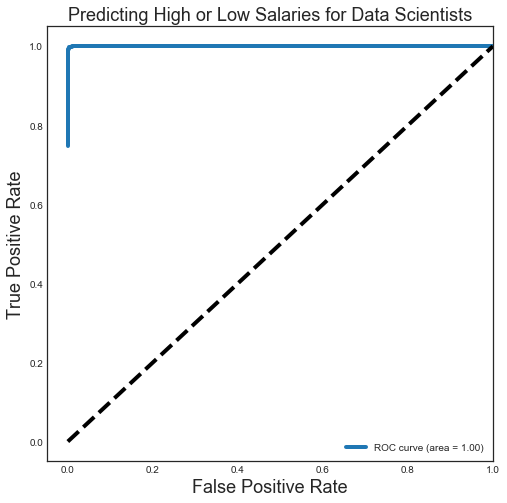

In [168]:
fpr, tpr, _ = roc_curve(y_test, Y_pp.class_1_pp)
roc_auc = auc(fpr, tpr)

# Plot of a ROC curve for class 1 (has_cancer).
plt.figure(figsize=[8,8])
plt.plot(fpr, tpr, label='ROC curve (area = %0.2f)' % roc_auc, linewidth=4)
plt.plot([0, 1], [0, 1], 'k--', linewidth=4)
plt.xlim([-0.05, 1.0])
plt.ylim([-0.05, 1.05])
plt.xlabel('False Positive Rate', fontsize=18)
plt.ylabel('True Positive Rate', fontsize=18)
plt.title('Predicting High or Low Salaries for Data Scientists', fontsize=18)
plt.legend(loc="lower right")
plt.show()

## Requirements

1. Scrape and prepare your own data.

2. **Create and compare at least two models for each section**. One of the two models should be a decision tree or ensemble model. The other can be a classifier or regression of your choosing (e.g. Ridge, logistic regression, KNN, SVM, etc).
   - Section 1: Job Salary Trends
   - Section 2: Job Category Factors

3. Prepare a polished Jupyter Notebook with your analysis for a peer audience of data scientists. 
   - Make sure to clearly describe and label each section.
   - Comment on your code so that others could, in theory, replicate your work.

4. A brief writeup in an executive summary, written for a non-technical audience.
   - Writeups should be at least 500-1000 words, defining any technical terms, explaining your approach, as well as any risks and limitations.

#### BONUS

5. Answer the salary discussion by using your model to explain the tradeoffs between detecting high vs low salary positions.

6. Convert your executive summary into a public blog post of at least 500 words, in which you document your approach in a tutorial for other aspiring data scientists. Link to this in your notebook.

---